In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

In [6]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, noise=0.1)

In [7]:
moon_x, moon_y = noisy_circles
moon_x = StandardScaler().fit_transform(moon_x)

In [8]:
colors = np.array(
    list(
        islice(
            cycle(
                [
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a",
                    "#f781bf",
                ]
            ),
            int(max(moon_y) + 1),
        )
    )
)

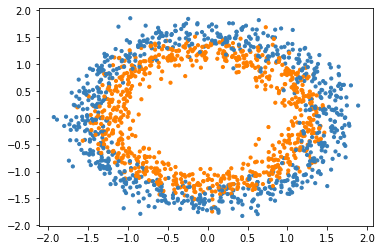

In [9]:
plt.scatter(moon_x[:,0], moon_x[:,1], color = colors[moon_y], s = 10)

In [10]:
import torch
import torch.nn as nn
import os, sys
from tony_dataset_2D import CTGdataset, CleanDataset
from neural_net_2D import Neural_Net, train_nn
torch.manual_seed(0)

In [11]:
Clean_Dataset = CleanDataset(moon_x, moon_y)

train_dataset, test_dataset = torch.utils.data.random_split(Clean_Dataset, 
    [int(0.9 * len(Clean_Dataset)), len(Clean_Dataset) - int(0.9 * len(Clean_Dataset))])
# training vs testing ratio is 6:4

In [49]:
grid_x = np.mgrid[-4:4:160j, -4:4:160j].reshape(2,-1).T
y = np.zeros(grid_x.shape[0])
grid_dataset = CleanDataset(grid_x, y)

In [13]:
def generate_data(model, test_dataset):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=len(test_dataset), 
                                            shuffle=True)
    # Iterate through test dataset, calculate testing accuracy
    for samples, labels in test_loader:
        outputs = model(samples)
        _, predicted = torch.max(outputs.data, 1)
    return samples, predicted

In [50]:
# Instantiate model class
input_dim = 2  # 2-dimensional space
hidden_dim = 30
output_dim = 2 # True or False - binary output
dropout_rate = 0.0
model = Neural_Net(input_dim, hidden_dim, output_dim, dropout_rate)

orig_stdout = sys.stdout

# Warmstart the neural networks
filepath = '../synthetic_data/2D/NN_generate_log.txt'
os.makedirs(os.path.dirname(filepath), exist_ok = True)

with open(filepath, 'w') as sys.stdout:
    batch_size = 50
    train_nn(model, train_dataset, test_dataset, batch_size = batch_size, l_r = 0.001, num_epochs = 100,
            optimizerName = "Adam")
    # Old comment
    # num_epochs is chosen to make the test accuracies of all 6 NN models to be less than 50%,
    # so that these models don't end up simply replicating the dataset

# Generate synthetic data with the neural networks
x, y = generate_data(model, grid_dataset)
x_df, y_df = pd.DataFrame(x.numpy()), pd.DataFrame(y.numpy())
x_df.to_csv('../synthetic_data/2D/NN_x.csv', index=False, header=False)
y_df.to_csv('../synthetic_data/2D/NN_y.csv', index=False, header=False)

sys.stdout = orig_stdout

In [15]:
for name, param in model.named_parameters():
    print (name)
    print(param.data)

fc1.weight
tensor([[ 0.2419,  0.6901],
        [-0.5787,  0.1604],
        [-0.2811, -0.3769],
        [-0.1600, -0.4930],
        [ 0.6351, -0.4260],
        [ 0.3271,  0.1545],
        [-0.0612, -0.6491],
        [-0.7499, -0.2949],
        [-0.8389,  0.0428],
        [ 0.0116, -0.0456],
        [-0.3311,  0.3873],
        [ 0.4134, -0.3259],
        [-0.4635,  0.5206],
        [ 0.4261, -0.6304],
        [-0.1528, -0.0656],
        [-0.2869,  0.7150],
        [-0.1092,  0.6643],
        [-0.0420, -0.0981],
        [-0.5727, -0.3326],
        [ 0.1067,  0.1852],
        [-0.0631,  0.4628],
        [-0.5141,  0.3106],
        [ 0.7612, -0.0412],
        [ 0.7231,  0.1323],
        [-0.3552, -0.2747],
        [ 0.3157, -0.3773],
        [ 0.2689,  0.8048],
        [ 0.2402, -0.0662],
        [ 0.2363, -0.2659],
        [-0.4743, -0.4302]])
fc1.bias
tensor([-0.5654,  0.2249, -0.0603, -0.3127, -0.4860,  0.6797, -0.4210, -0.0947,
        -0.6114, -0.3989,  0.5683, -0.6187, -0.3830,  0.770

In [16]:
from torch.utils.tensorboard import SummaryWriter

# SummaryWriter.add_graph requires sample input data
trainloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=len(train_dataset), 
                                            shuffle=True)
dataiter = iter(trainloader)
features, labels = dataiter.next()

tb = SummaryWriter()
tb.add_graph(model, features)
tb.close()

In [51]:
NN_x = pd.read_csv("../synthetic_data/2D/NN_x.csv", header = None)
NN_y = pd.read_csv("../synthetic_data/2D/NN_y.csv", header = None)
NN_x, NN_y = np.array(NN_x), (np.array(NN_y)).flatten()

In [52]:
assert len(NN_x) == len(NN_y)
p = np.random.permutation(len(NN_x))
NN_x_p, NN_y_p = NN_x[p], NN_y[p]
stop = int(len(NN_x) / 10)

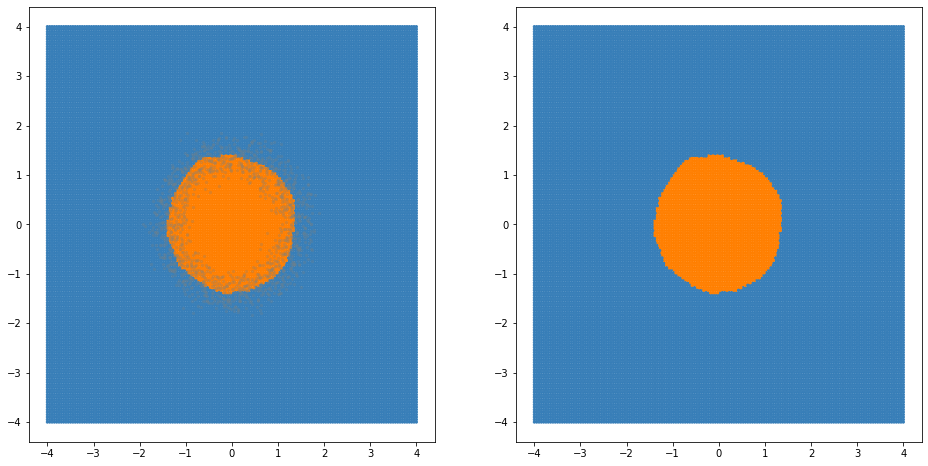

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
## fig.suptitle('NN generated predictions')
fig

ax1.scatter(NN_x_p[:,0], NN_x_p[:,1], color = colors[NN_y_p[:]], s = 5)
ax1.scatter(moon_x[:,0], moon_x[:,1], color = 'gray', s = 5, alpha = 0.2)

ax2.scatter(NN_x_p[:,0], NN_x_p[:,1], color = colors[NN_y_p[:]], s = 5)

In [26]:
# context manager - used with "with" statement
# result: the added path is removed after execution of the indented block
class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass

In [55]:
with add_path('../'): # allow code within block to reach modules one directory level up
    from scikit_obliquetree.HHCART import HouseHolderCART
    from scikit_obliquetree.segmentor import MeanSegmentor, TotalSegmentor, Gini
    from sklearn.metrics import accuracy_score

    sgmtr = TotalSegmentor()
    HHTree = HouseHolderCART(impurity = Gini(), segmentor = sgmtr, max_depth = 5, min_samples = 5)
    # HHTree.fit(moon_x, moon_y)
    HHTree.fit(NN_x, NN_y)
    nodes = HHTree._nodes
    train_score = accuracy_score(moon_y, HHTree.predict(moon_x))
    print("train_score: ", train_score)
    grid_y_pred = HHTree.predict(grid_x)
    grid_y_pred = grid_y_pred.astype(int)

train_score:  0.756


In [75]:
with add_path('../'): # allow code within block to reach modules one directory level up
    from scikit_obliquetree.HHCART import HouseHolderCART
    from scikit_obliquetree.segmentor import MeanSegmentor, TotalSegmentor, Gini
    from sklearn.metrics import accuracy_score

    sgmtr = TotalSegmentor()
    HHTree2 = HouseHolderCART(impurity = Gini(), segmentor = sgmtr, max_depth = 5, min_samples = 8)
    HHTree2.fit(moon_x, moon_y)
    # HHTree2.fit(NN_x, NN_y)
    nodes2 = HHTree2._nodes
    train_score = accuracy_score(moon_y, HHTree2.predict(moon_x))
    print("train_score: ", train_score)
    grid_y_pred = HHTree2.predict(grid_x)
    grid_y_pred = grid_y_pred.astype(int)

train_score:  0.806


In [56]:
# 5760 data points, smaller outer set

In [73]:
print(f"number of nodes on this tree: {len(nodes2)}")
leaf_count = sum([1 if node.is_leaf else 0 for node in nodes2])
print(f"number of leaf nodes: {leaf_count}")
print(f"root node depth: {HHTree2._root.depth}")
print()
for node in nodes2:
    if node.is_leaf:
        print(f"Leaf depth is: {node.depth}")

number of nodes on this tree: 81
number of leaf nodes: 41
root node depth: 0

Leaf depth is: 6
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 5
Leaf depth is: 5
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 5
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 4
Leaf depth is: 6
Leaf depth is: 6
Leaf depth is: 6
Leaf depth is: 7
Leaf depth is: 7
Leaf depth is: 6
Leaf depth is: 6
Leaf depth is: 5
Leaf depth is: 5
Leaf depth is: 5
Leaf depth is: 5
Leaf depth is: 6
Leaf depth is: 6
Leaf depth is: 4
Leaf depth is: 3
Leaf depth is: 4
Leaf depth is: 4
Leaf depth is: 3


In [60]:
for n in nodes:
    if not n.is_leaf:
        print(n._weights)

[ 0.99995665  0.00931123 -1.38241659]
[ 0.99998633  0.00522794 -1.38481258]
[ 0.99995744  0.00922624 -1.28737422]
[ 0.9999576   0.00920818 -1.32980209]
[ 0.99998652  0.00519271 -1.33527494]
[1.         0.         0.02515723]
[ 0.         1.        -1.3836478]
[-0.03865647  0.99925256 -1.01997827]
[-0.07373413 -0.99727793 -1.38544626]
[-0.00826496  0.99996584  1.2894206 ]
[-0.01022477  0.99994773 -1.3371221 ]
[ 0.99996562  0.00829165 -1.2378769 ]
[1.00000000e+00 2.22044605e-16 1.33333340e+00]


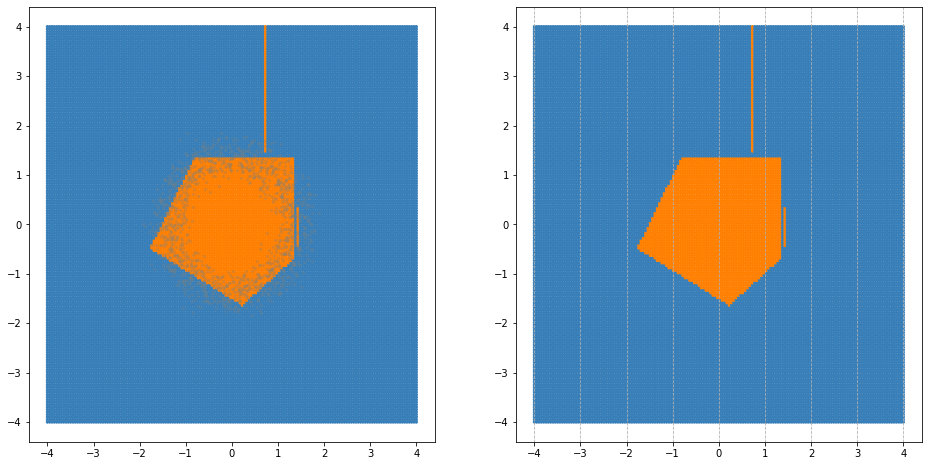

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
# fig.suptitle('tree generated predictions')
fig

ax1.scatter(grid_x[:,0], grid_x[:,1], color = colors[grid_y_pred], s = 5)
ax1.scatter(moon_x[:,0], moon_x[:,1], color = 'gray', s = 5, alpha = 0.2)

ax2.scatter(grid_x[:,0], grid_x[:,1], color = colors[grid_y_pred], s = 5)

'''
for node in nodes:
    if node._weights is not None and node._weights[0] == 1.:
        ax2.axvline(node._weights[-1], ymin = -10, ymax = 10, lw = 0.8, c = 'r')
ax2.axline((0, -0.5854), slope = 1, lw = 0.8, c = 'r')
ax2.axline((0, 0.7852), slope = -0.6885 / 0.7252, lw = 0.8, c = 'r')
'''

plt.grid(axis = "x", linestyle = "--")

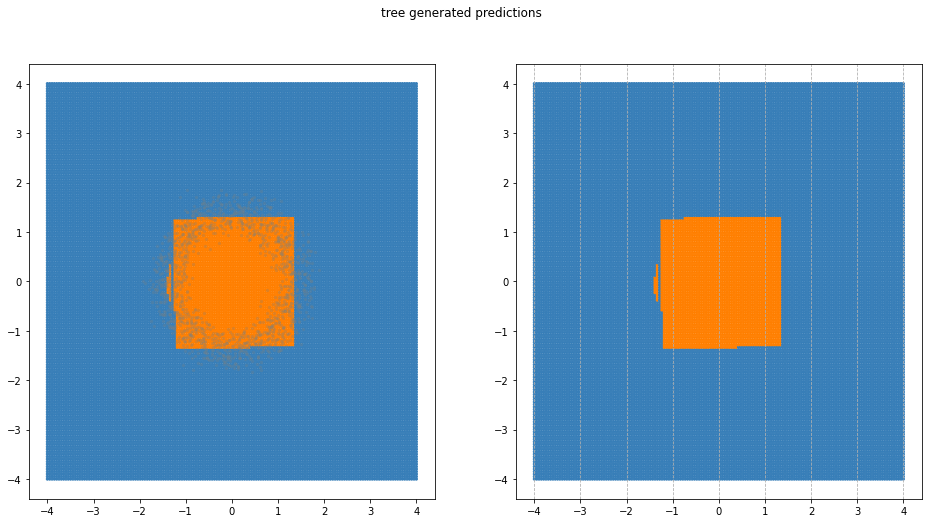

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('tree generated predictions')
fig

ax1.scatter(grid_x[:,0], grid_x[:,1], color = colors[grid_y_pred], s = 5)
ax1.scatter(moon_x[:,0], moon_x[:,1], color = 'gray', s = 5, alpha = 0.2)

ax2.scatter(grid_x[:,0], grid_x[:,1], color = colors[grid_y_pred], s = 5)

'''
for node in nodes:
    if node._weights is not None and node._weights[0] == 1.:
        ax2.axvline(node._weights[-1], ymin = -10, ymax = 10, lw = 0.8, c = 'r')
ax2.axline((0, -0.5854), slope = 1, lw = 0.8, c = 'r')
ax2.axline((0, 0.7852), slope = -0.6885 / 0.7252, lw = 0.8, c = 'r')
'''

plt.grid(axis = "x", linestyle = "--")